In [1]:
## Standard libraries
import os
import json
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
CHECKPOINT_PATH = "../saved_models"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

<ipython-input-1-e2d4f9889466>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


cuda:0


In [2]:
torch.use_deterministic_algorithms(True)

In [3]:
import random

random.seed(42)

In [4]:
from torch_geometric.utils import from_networkx    

import numpy as np
import os
import networkx as nx
import torch

In [5]:
#Pytorch Geometric
import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [6]:
#for sampling random graphs
from torch_cluster import radius_graph #to build random geometric graphs, given the positions in 2D and the radius
from torch_geometric.utils import erdos_renyi_graph, stochastic_blockmodel_graph, barabasi_albert_graph

In [7]:
#Different GNN architectures from pytorch geometric
gnn_layer_by_name = {
    "GCN": geom_nn.GCNConv,
    "GAT": geom_nn.GATConv,
    "GraphConv": geom_nn.GraphConv,
    "ChebNet": geom_nn.ChebConv,
    "GraphSage": geom_nn.SAGEConv
}

In [8]:
def SBM_Gen(N, blocks, edge_prob_block, edge_prob_all=0):
    """
    Generates a SBM graph in [0,1] by first sampling random uniformly N nodes. Then, seperating 
    them according to blocks, block are floats seperting [0,1], i.e., list of length number_of_blocks
    edge_prob_block: list of length number_of_blocks: every element give the edge_probability in it. 
    edge_prob_all: integer giving the interblock probabiltiy of an edge.
    """
    s = np.random.uniform(0,1, N)
    intervals = blocks
    sizes = []
    for i in range(0, len(intervals)):
        size = 0
        for j in range(0, len(s)):
            if i == 0:
                if s[j] > 0 and s[j] <= intervals[0]:
                    size = size + 1
            elif s[j] > intervals[i-1] and s[j] <= intervals[i]:
                size = size+1
        sizes.append(size)
        
    ss = torch.tensor(s).reshape(N,1)
    probsPerInt = edge_prob_block
    y = edge_prob_all
    
    probs = []
    for i in range(0, len(probsPerInt)):
        prob = [y] * len(probsPerInt)
        prob[i] = probsPerInt[i]
        probs.append(prob)
    
    return nx.stochastic_block_model(sizes,probs,seed=0)

In [9]:
def make_datalist(sz, gr_number):
    """
    Input: - sz: int, size of the output graphs 
           - gr_number: int, size of the output data set
        
    Generates gr_number of graph of size for 8 different graphon model.
   
    Output: A list data_list of size 8*gr_number. Each element is a Data-Graph with sz nodes. Generated from 8 different graphon models
    """
    
    
    dl = []
    
    radius = 0.1

    for i in range(0,gr_number):
        pos = torch.rand(sz,2)

        batch = torch.zeros(int(sz)).type(torch.LongTensor)
        #x = low_pass(pos).reshape(50,1)
        x = torch.ones(sz).reshape(sz,1)
        edge_index = radius_graph(pos, r=radius, batch=batch, loop=False, max_num_neighbors=sz)
        gr  = Data(x=x,  edge_index = edge_index, y=torch.ones(1).to(torch.long))


        dl.append(gr)
    radius = 0.5

    for i in range(0,gr_number):
        pos = torch.rand(sz,2)

        batch = torch.zeros(int(sz)).type(torch.LongTensor)
        #x = low_pass(pos).reshape(50,1)
        x = torch.ones(sz).reshape(sz,1) 
        edge_index = radius_graph(pos, r=radius, batch=batch, loop=False, max_num_neighbors=(sz))
        gr  = Data(x=x,  edge_index = edge_index, y=torch.zeros(1).to(torch.long))


        dl.append(gr)
    p = 0.1

    for i in range(0,gr_number):
        x = torch.ones(sz).reshape(sz,1)
        edge_index = erdos_renyi_graph(sz, p)
        gr  = Data(x=x,  edge_index = edge_index, y=2*torch.ones(1).to(torch.long))

        dl.append(gr)   
    p = 0.5

    for i in range(0,gr_number):
        x = torch.ones(sz).reshape(sz,1)
        edge_index = erdos_renyi_graph(sz, p)
        gr  = Data(x=x,  edge_index = edge_index, y=3*torch.ones(1).to(torch.long))

        dl.append(gr)
        
    blocks = [1/8, 2/8, 3/8,4/8,5/8,6/8,7/8,1]
    edge_prob_block = [4/8, 1/8, 1/32,1/32,1/16,1/3,1/8,1/64]

    for i in range(0,gr_number):
        g = SBM_Gen(sz, blocks, edge_prob_block, edge_prob_all=1/4)
        g = from_networkx(g)
        g.y = 4*torch.ones(1).to(torch.long)
        g.x = torch.ones(g.num_nodes).reshape(g.num_nodes, 1)
        del g.num_nodes
        del g.block
        dl.append(g)    
        
    blocks = [1/4, 2/4, 3/4, 1]
    edge_prob_block = [6/16, 1/16, 2/16, 3/16]

    for i in range(0,gr_number):
        g = SBM_Gen(sz, blocks, edge_prob_block, edge_prob_all=0)
        g = from_networkx(g)
        g.y = 5*torch.ones(1).to(torch.long)
        g.x = torch.ones(g.num_nodes).reshape(g.num_nodes, 1)
        del g.num_nodes
        del g.block
        dl.append(g)
 
    p = 5

    for i in range(0,gr_number):
        x = torch.ones(sz).reshape(sz,1)
        edge_index = barabasi_albert_graph(sz, p)
        gr  = Data(x=x,  edge_index = edge_index, y=6*torch.ones(1).to(torch.long))

        dl.append(gr)
        
    p = 10

    for i in range(0,gr_number):
        x = torch.ones(sz).reshape(sz,1)
        edge_index = barabasi_albert_graph(sz, p)
        gr  = Data(x=x,  edge_index = edge_index, y=7*torch.ones(1).to(torch.long))

        dl.append(gr)
    return dl

In [10]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="GCN", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [11]:
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in,
                            c_hidden=c_hidden,
                            c_out=c_hidden, # Not our prediction output yet!
                            **kwargs)
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
        x = self.head(x)
        return x

In [12]:
class GraphLevelGNN(pl.LightningModule):

    def __init__(self, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        self.model = GraphGNNModel(**model_kwargs)
        self.loss_module = nn.BCEWithLogitsLoss() if self.hparams.c_out == 1 else nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        x, edge_index, batch_idx = data.x, data.edge_index, data.batch
        x = self.model(x, edge_index, batch_idx)
        x = x.squeeze(dim=-1)

        if self.hparams.c_out == 1:
            preds = (x > 0).float()
            data.y = data.y.float()
        else:
            preds = x.argmax(dim=-1)
        loss = self.loss_module(x, data.y)
        acc = (preds == data.y).sum().float() / preds.shape[0]
        return loss, acc

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-2, weight_decay=0.0) # High lr because of small dataset and small model
        return optimizer

    def training_step(self, batch, batch_idx):
        pass
        loss, acc = self.forward(batch, mode="train")
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        _, acc = self.forward(batch, mode="val")
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="test")
        self.log('test_loss', loss)
        self.log('test_acc', acc)

In [14]:
def train_graph_classifier(model_name, **model_kwargs):
    pl.seed_everything(42)

    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=5,
                         progress_bar_refresh_rate=0)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"GraphLevel{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GraphLevelGNN.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = GraphLevelGNN(c_in=1,  #this is the input dimension, i.e., x.size() = n x c_in
                              c_out=8, #this is the number of classes, i.e., change it accordingly
                              **model_kwargs)
        trainer.fit(model, graph_train_loader, graph_val_loader)
        model = GraphLevelGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # Test best model on validation and test set
    train_result = trainer.test(model, test_dataloaders=graph_train_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=graph_test_loader, verbose=False)
    result = {"test": test_result[0]['test_acc'], "train": train_result[0]['test_acc']}
    return model, result

In [15]:
train_acc100 = []
test_acc100 = []
train_loss100 = []
test_loss100 = []

In [16]:
for i in range(0,2):
    data_list = make_datalist(100, 50)

    random.seed(42)
    random.shuffle(data_list)

    train_dataset = data_list[:200]
    test_dataset = data_list[200:]

    graph_train_loader = geom_data.DataLoader(train_dataset, batch_size=8)
    graph_val_loader = geom_data.DataLoader(test_dataset, batch_size=8) # Additional loader if you want to change to a larger dataset
    graph_test_loader = geom_data.DataLoader(test_dataset, batch_size=8)
    
    model, result = train_graph_classifier(model_name="ChebNet",
                                       c_hidden=256,
                                       layer_name="ChebNet",
                                       num_layers=3,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0,
                                       K=2
                                      )
    train_acc100.append(result['train'])
    test_acc100.append(result['test'])
    
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + "ChebNet")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         #callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         #max_epochs=2,
                         #progress_bar_refresh_rate=0
                    )
    
    with torch.no_grad():
        test_result = trainer.test(model, test_dataloaders=graph_train_loader, verbose=False)
        train_loss100.append(test_result[0]['test_loss'])
        test_result = trainer.test(model, test_dataloaders=graph_test_loader, verbose=False)
        test_loss100.append(test_result[0]['test_loss'])
        

/home/math/maskey/anaconda3/envs/pyg_cuda102/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Global seed set to 42
/home/math/maskey/anaconda3/envs/pyg_cuda102/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name        | Type             | Params
---------------------------------------

Testing: 100%|██████████| 25/25 [00:00<00:00, 175.72it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]



Testing: 100%|██████████| 25/25 [00:00<00:00, 182.21it/s]


Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GraphGNNModel    | 265 K 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.062     Total estimated model params size (MB)
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 100%|██████████| 25/25 [00:00<00:00, 178.89it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]



Testing: 100%|██████████| 25/25 [00:00<00:00, 177.65it/s]


No handles with labels found to put in legend.


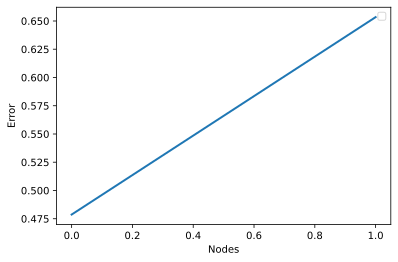

In [20]:
xAxis = [i for i in range(0,2)]
fig = plt.figure()
plt.xlabel('Nodes')
plt.ylabel('Error')
#txt="radius: " + str((radius)/10)
#plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=15)
plt.plot(xAxis,train_acc100)
plt.legend()
fig.savefig('loss_gap.png', dpi=350)
plt.show()

In [18]:
train_acc100

[0.4786931872367859, 0.6534090638160706]

In [19]:
for i in range(0,1):
    data_list = make_datalist(50, 50)

    random.seed(42)
    random.shuffle(data_list)

    train_dataset = data_list[:200]
    test_dataset = data_list[200:]

    graph_train_loader = geom_data.DataLoader(train_dataset, batch_size=64)
    graph_val_loader = geom_data.DataLoader(test_dataset, batch_size=64) # Additional loader if you want to change to a larger dataset
    graph_test_loader = geom_data.DataLoader(test_dataset, batch_size=64)
    
    model, result = train_graph_classifier(model_name="ChebNet",
                                       c_hidden=256,
                                       layer_name="ChebNet",
                                       num_layers=3,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0,
                                       K=2
                                      )
    train_acc50.append(result['train'])
    test_acc50.append(result['test'])
    
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + "ChebNet")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         #callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         #max_epochs=2,
                         #progress_bar_refresh_rate=0
                    )
    
    with torch.no_grad():
        test_result = trainer.test(model, test_dataloaders=graph_train_loader, verbose=False)
        train_loss50.append(test_result[0]['test_loss'])
        test_result = trainer.test(model, test_dataloaders=graph_test_loader, verbose=False)
        test_loss50.append(test_result[0]['test_loss'])
        

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GraphGNNModel    | 265 K 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.062     Total estimated model params size (MB)
Global seed set to 42
/home/math/maskey/anaconda3/envs/pyg_cuda102/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:412: UserWarning: The number of training samples (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES

Testing: 100%|██████████| 4/4 [00:00<00:00, 132.57it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 4/4 [00:00<00:00, 151.96it/s]


In [20]:
print(train_acc50 , train_loss50, test_acc50, test_loss50)

[0.9050480723381042] [0.28879228234291077] [0.91796875] [0.30749523639678955]


In [21]:
sum_list = []

for (item1, item2) in zip(test_loss100, train_loss100):

    sum_list.append(np.abs(item2-item1))


print(sum(sum_list) / len(sum_list))

0.04988503456115723


In [22]:
sum_list = []

for (item1, item2) in zip(test_loss50, train_loss50):

    sum_list.append(np.abs(item2-item1))


print(sum(sum_list) / len(sum_list))

0.018702954053878784


In [61]:
train_acc200 = []
test_acc200 = []
train_loss200 = []
test_loss200 = []

In [65]:
for i in range(0,1):
    data_list = make_datalist(800, 50)

    random.seed(42)
    random.shuffle(data_list)

    train_dataset = data_list[:200]
    test_dataset = data_list[200:]

    graph_train_loader = geom_data.DataLoader(train_dataset, batch_size=2)
    graph_val_loader = geom_data.DataLoader(test_dataset, batch_size=2) # Additional loader if you want to change to a larger dataset
    graph_test_loader = geom_data.DataLoader(test_dataset, batch_size=2)
    
    model, result = train_graph_classifier(model_name="ChebNet",
                                       c_hidden=256,
                                       layer_name="ChebNet",
                                       num_layers=3,
                                       dp_rate_linear=0.5,
                                       dp_rate=0.0,
                                       K=2
                                      )
    train_acc200.append(result['train'])
    test_acc200.append(result['test'])
    
    root_dir = os.path.join(CHECKPOINT_PATH, "GraphLevel" + "ChebNet")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         #callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         #max_epochs=2,
                         #progress_bar_refresh_rate=0
                    )
    
    with torch.no_grad():
        test_result = trainer.test(model, test_dataloaders=graph_train_loader, verbose=False)
        train_loss200.append(test_result[0]['test_loss'])
        test_result = trainer.test(model, test_dataloaders=graph_test_loader, verbose=False)
        test_loss200.append(test_result[0]['test_loss'])
        

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GraphGNNModel    | 265 K 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
265 K     Trainable params
0         Non-trainable params
265 K     Total params
1.062     Total estimated model params size (MB)
Global seed set to 42
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 100/100 [00:01<00:00, 87.31it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing: 100%|██████████| 100/100 [00:01<00:00, 84.65it/s]


In [66]:
sum_list = []

for (item1, item2) in zip(test_loss200, train_loss200):

    sum_list.append(np.abs(item2-item1))


print(sum(sum_list) / len(sum_list))

0.08072051405906677


In [67]:
result

{'test': 0.4214285612106323, 'train': 0.35504886507987976}

In [68]:
test_acc200

[0.98828125, 0.4214285612106323]